# 도쿄 기상예측

In [1]:
!pip install meteostat

  Obtaining dependency information for meteostat from https://files.pythonhosted.org/packages/90/23/34e8913fa75d064be09303914ea0056ef2968b639ebc8e70decfecd8299b/meteostat-1.6.8-py3-none-any.whl.metadata


# library import

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from meteostat import Point, Hourly
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')

# 도쿄기온예측클래스

In [ ]:
class TokyoWeatherPredictor:
    def __init__(self):
        """도쿄 기온 예측 모델 초기화"""
        # 도쿄 좌표 (위도, 경도, 고도)
        self.tokyo_point = Point(35.6762, 139.6503, 70)
        self.model = None
        self.data = None
        self.train_data = None
        self.test_data = None
        
    def collect_weather_data(self, years=5):
        """
        Meteostat을 사용하여 도쿄의 시간대별 기온 데이터 수집
        
        Args:
            years (int): 수집할 데이터의 연도 수
        """
        print("🌡️ 도쿄 기온 데이터 수집 중...")
        
        # 데이터 수집 기간 설정 (현재로부터 과거 n년)
        end_date = datetime.now()
        start_date = end_date - timedelta(days=365 * years)
        
        # 시간대별 기상 데이터 수집
        data = Hourly(self.tokyo_point, start_date, end_date)
        self.data = data.fetch()
        
        # 데이터 전처리
        self.data = self.data.reset_index()
        self.data = self.data[['time', 'temp']].dropna()
        
        # Prophet 모델용 컬럼명 변경
        self.data.columns = ['ds', 'y']
        
        print(f"✅ 데이터 수집 완료: {len(self.data)}개 시간대별 기록")
        print(f"📅 기간: {start_date.strftime('%Y-%m-%d')} ~ {end_date.strftime('%Y-%m-%d')}")
        
        return self.data
    
    def explore_data(self):
        """데이터 탐색 및 시각화"""
        if self.data is None:
            print("❌ 먼저 데이터를 수집해주세요.")
            return
            
        print("\n📊 데이터 탐색")
        print("="*50)
        print(f"데이터 형태: {self.data.shape}")
        print(f"기간: {self.data['ds'].min()} ~ {self.data['ds'].max()}")
        print(f"평균 기온: {self.data['y'].mean():.2f}°C")
        print(f"최고 기온: {self.data['y'].max():.2f}°C")
        print(f"최저 기온: {self.data['y'].min():.2f}°C")
        print(f"결측값: {self.data.isnull().sum().sum()}개")
        
        # 시각화
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle('도쿄 기온 데이터 탐색', fontsize=16, fontweight='bold')
        
        # 1. 시계열 플롯
        axes[0,0].plot(self.data['ds'], self.data['y'], alpha=0.7, linewidth=0.5)
        axes[0,0].set_title('시간대별 기온 변화')
        axes[0,0].set_xlabel('날짜')
        axes[0,0].set_ylabel('기온 (°C)')
        axes[0,0].grid(True, alpha=0.3)
        
        # 2. 기온 분포 히스토그램
        axes[0,1].hist(self.data['y'], bins=50, alpha=0.7, color='skyblue')
        axes[0,1].set_title('기온 분포')
        axes[0,1].set_xlabel('기온 (°C)')
        axes[0,1].set_ylabel('빈도')
        axes[0,1].grid(True, alpha=0.3)
        
        # 3. 월별 기온 박스플롯
        monthly_data = self.data.copy()
        monthly_data['month'] = monthly_data['ds'].dt.month
        monthly_data.boxplot(column='y', by='month', ax=axes[1,0])
        axes[1,0].set_title('월별 기온 분포')
        axes[1,0].set_xlabel('월')
        axes[1,0].set_ylabel('기온 (°C)')
        
        # 4. 시간대별 기온 박스플롯
        hourly_data = self.data.copy()
        hourly_data['hour'] = hourly_data['ds'].dt.hour
        hourly_sample = hourly_data.groupby('hour')['y'].apply(lambda x: x.sample(min(len(x), 1000))).reset_index(drop=True)
        hourly_sample_df = pd.DataFrame({
            'hour': hourly_data.groupby('hour').apply(lambda x: [x.name] * min(len(x), 1000)).explode().values,
            'temp': hourly_sample
        })
        hourly_sample_df.boxplot(column='temp', by='hour', ax=axes[1,1])
        axes[1,1].set_title('시간대별 기온 분포')
        axes[1,1].set_xlabel('시간')
        axes[1,1].set_ylabel('기온 (°C)')
        
        plt.tight_layout()
        plt.show()
    
    def split_data(self, recent_test_days=30):
        """
        데이터를 훈련용과 테스트용으로 분할
        최근 한 달은 테스트용으로, 나머지는 훈련용으로 사용
        
        Args:
            recent_test_days (int): 최근 며칠을 테스트 데이터로 사용할지 (기본값: 30일)
        """
        if self.data is None:
            print("❌ 먼저 데이터를 수집해주세요.")
            return
            
        print(f"📊 최근 {recent_test_days}일을 테스트 데이터로 분할 중...")
        
        # 최근 30일 분리
        cutoff_date = self.data['ds'].max() - timedelta(days=recent_test_days)
        
        self.train_data = self.data[self.data['ds'] <= cutoff_date].copy()
        self.test_data = self.data[self.data['ds'] > cutoff_date].copy()
        
        print(f"📊 데이터 분할 완료")
        print(f"훈련 데이터: {len(self.train_data)}개 ({self.train_data['ds'].min().strftime('%Y-%m-%d')} ~ {self.train_data['ds'].max().strftime('%Y-%m-%d')})")
        print(f"테스트 데이터: {len(self.test_data)}개 ({self.test_data['ds'].min().strftime('%Y-%m-%d')} ~ {self.test_data['ds'].max().strftime('%Y-%m-%d')})")
        print(f"📅 테스트 기간: 최근 {recent_test_days}일 ({(self.test_data['ds'].max() - self.test_data['ds'].min()).days + 1}일)")
        
        return self.train_data, self.test_data
    
    def train_model(self, seasonality_mode='multiplicative'):
        """Prophet 모델 훈련"""
        if self.train_data is None:
            print("❌ 먼저 데이터를 분할해주세요.")
            return
            
        print("🤖 Prophet 모델 훈련 중...")
        
        # Prophet 모델 설정
        self.model = Prophet(
            seasonality_mode=seasonality_mode,
            daily_seasonality=True,
            weekly_seasonality=True,
            yearly_seasonality=True,
            changepoint_prior_scale=0.05,
            seasonality_prior_scale=10.0
        )
        
        # 모델 훈련
        self.model.fit(self.train_data)
        
        print("✅ 모델 훈련 완료")
        
        return self.model
    
    def evaluate_model(self, detailed_analysis=True):
        """
        모델 성능 평가 (최근 한 달 데이터 기준)
        
        Args:
            detailed_analysis (bool): 상세 분석 수행 여부
        """
        if self.model is None or self.test_data is None:
            print("❌ 먼저 모델을 훈련하고 데이터를 분할해주세요.")
            return
            
        print("📈 모델 성능 평가 중 (최근 한 달 데이터 기준)...")
        
        # 테스트 데이터에 대한 예측
        forecast = self.model.predict(self.test_data[['ds']])
        
        # 성능 지표 계산
        actual = self.test_data['y'].values
        predicted = forecast['yhat'].values
        
        mae = mean_absolute_error(actual, predicted)
        rmse = np.sqrt(mean_squared_error(actual, predicted))
        mape = np.mean(np.abs((actual - predicted) / actual)) * 100
        
        # 상관계수 계산
        correlation = np.corrcoef(actual, predicted)[0, 1]
        
        print("="*60)
        print("📊 모델 성능 지표 (최근 한 달 기준)")
        print("="*60)
        print(f"MAE (평균절대오차): {mae:.2f}°C")
        print(f"RMSE (평균제곱근오차): {rmse:.2f}°C")
        print(f"MAPE (평균절대백분율오차): {mape:.2f}%")
        print(f"상관계수: {correlation:.3f}")
        
        # 성능 해석
        if mae <= 2.0:
            performance = "🟢 우수"
        elif mae <= 3.5:
            performance = "🟡 양호" 
        else:
            performance = "🔴 개선 필요"
            
        print(f"종합 성능: {performance}")
        
        if detailed_analysis:
            # 일별 성능 분석
            test_with_pred = self.test_data.copy()
            test_with_pred['predicted'] = predicted
            test_with_pred['abs_error'] = np.abs(actual - predicted)
            test_with_pred['date'] = test_with_pred['ds'].dt.date
            
            daily_performance = test_with_pred.groupby('date').agg({
                'y': ['mean', 'min', 'max'],
                'predicted': ['mean', 'min', 'max'],
                'abs_error': ['mean', 'max']
            }).round(2)
            
            daily_performance.columns = ['실제_평균', '실제_최저', '실제_최고', 
                                       '예측_평균', '예측_최저', '예측_최고',
                                       '평균오차', '최대오차']
            
            print(f"\n📅 일별 성능 분석 (최근 {len(daily_performance)}일)")
            print("="*100)
            print(daily_performance.head(10))
            
            # 시간대별 성능 분석
            test_with_pred['hour'] = test_with_pred['ds'].dt.hour
            hourly_performance = test_with_pred.groupby('hour')['abs_error'].agg(['mean', 'std']).round(2)
            
            print(f"\n🕐 시간대별 평균 오차 (상위 5개 시간대)")
            print("="*50)
            worst_hours = hourly_performance.sort_values('mean', ascending=False).head()
            for hour, (mean_error, std_error) in worst_hours.iterrows():
                print(f"{hour:2d}시: {mean_error:.2f}°C (±{std_error:.2f}°C)")
        
        # 시각화
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('모델 성능 평가 (최근 한 달)', fontsize=16, fontweight='bold')
        
        # 1. 실제값 vs 예측값 시계열
        axes[0,0].plot(self.test_data['ds'], actual, label='실제값', alpha=0.8, linewidth=1.5)
        axes[0,0].plot(self.test_data['ds'], predicted, label='예측값', alpha=0.8, linewidth=1.5)
        axes[0,0].fill_between(self.test_data['ds'], 
                              forecast['yhat_lower'], 
                              forecast['yhat_upper'], 
                              alpha=0.2, label='예측 구간')
        axes[0,0].set_title('실제 기온 vs 예측 기온 (시계열)')
        axes[0,0].set_xlabel('날짜')
        axes[0,0].set_ylabel('기온 (°C)')
        axes[0,0].legend()
        axes[0,0].grid(True, alpha=0.3)
        
        # 2. 산점도 (실제 vs 예측)
        axes[0,1].scatter(actual, predicted, alpha=0.6, s=10)
        min_temp = min(actual.min(), predicted.min())
        max_temp = max(actual.max(), predicted.max())
        axes[0,1].plot([min_temp, max_temp], [min_temp, max_temp], 'r--', alpha=0.8)
        axes[0,1].set_title(f'실제값 vs 예측값 산점도\n(상관계수: {correlation:.3f})')
        axes[0,1].set_xlabel('실제 기온 (°C)')
        axes[0,1].set_ylabel('예측 기온 (°C)')
        axes[0,1].grid(True, alpha=0.3)
        
        # 3. 오차 시계열
        residuals = actual - predicted
        axes[1,0].plot(self.test_data['ds'], residuals, alpha=0.7, linewidth=1)
        axes[1,0].axhline(y=0, color='red', linestyle='--', alpha=0.8)
        axes[1,0].axhline(y=mae, color='orange', linestyle=':', alpha=0.8, label=f'MAE: {mae:.2f}°C')
        axes[1,0].axhline(y=-mae, color='orange', linestyle=':', alpha=0.8)
        axes[1,0].set_title('예측 오차 시계열')
        axes[1,0].set_xlabel('날짜')
        axes[1,0].set_ylabel('오차 (실제값 - 예측값, °C)')
        axes[1,0].legend()
        axes[1,0].grid(True, alpha=0.3)
        
        # 4. 오차 히스토그램
        axes[1,1].hist(residuals, bins=30, alpha=0.7, edgecolor='black')
        axes[1,1].axvline(x=0, color='red', linestyle='--', alpha=0.8)
        axes[1,1].axvline(x=residuals.mean(), color='orange', linestyle=':', alpha=0.8, 
                         label=f'평균 오차: {residuals.mean():.2f}°C')
        axes[1,1].set_title('오차 분포')
        axes[1,1].set_xlabel('오차 (°C)')
        axes[1,1].set_ylabel('빈도')
        axes[1,1].legend()
        axes[1,1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # 성능 요약 반환
        performance_summary = {
            'MAE': mae,
            'RMSE': rmse, 
            'MAPE': mape,
            'correlation': correlation,
            'test_period_days': (self.test_data['ds'].max() - self.test_data['ds'].min()).days + 1,
            'performance_grade': performance
        }
        
        if detailed_analysis:
            performance_summary['daily_performance'] = daily_performance
            performance_summary['hourly_performance'] = hourly_performance
        
        return performance_summary
    
    def predict_future(self, days=7):
        """미래 기온 예측"""
        if self.model is None:
            print("❌ 먼저 모델을 훈련해주세요.")
            return
            
        print(f"🔮 {days}일간의 미래 기온 예측 중...")
        
        # 미래 날짜 생성 (시간단위)
        last_date = self.data['ds'].max()
        future_dates = pd.date_range(
            start=last_date + timedelta(hours=1),
            periods=days * 24,
            freq='H'
        )
        
        future_df = pd.DataFrame({'ds': future_dates})
        
        # 예측 수행
        forecast = self.model.predict(future_df)
        
        # 결과 정리
        prediction_result = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].copy()
        prediction_result.columns = ['날짜시간', '예측기온', '최저예상', '최고예상']
        
        # 일별 요약 통계
        daily_summary = prediction_result.groupby(prediction_result['날짜시간'].dt.date).agg({
            '예측기온': ['min', 'max', 'mean'],
            '최저예상': 'min',
            '최고예상': 'max'
        }).round(2)
        
        daily_summary.columns = ['최저기온', '최고기온', '평균기온', '최저구간', '최고구간']
        
        print("✅ 예측 완료")
        print("\n📅 일별 기온 예측 요약")
        print("="*70)
        print(daily_summary)
        
        # 시각화
        fig, ax = plt.subplots(1, 1, figsize=(15, 8))
        
        # 최근 7일 실제 데이터
        recent_data = self.data.tail(168)  # 최근 7일 (7*24시간)
        ax.plot(recent_data['ds'], recent_data['y'], 
                label='최근 실제 기온', color='blue', alpha=0.8)
        
        # 미래 예측 데이터
        ax.plot(prediction_result['날짜시간'], prediction_result['예측기온'], 
                label='예측 기온', color='red', alpha=0.8)
        ax.fill_between(prediction_result['날짜시간'],
                       prediction_result['최저예상'],
                       prediction_result['최고예상'],
                       alpha=0.3, color='red', label='예측 구간')
        
        ax.axvline(x=last_date, color='gray', linestyle='--', alpha=0.7, label='예측 시작점')
        ax.set_title(f'도쿄 기온 예측 ({days}일간)')
        ax.set_xlabel('날짜')
        ax.set_ylabel('기온 (°C)')
        ax.legend()
        ax.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
        return prediction_result, daily_summary
    
    def recommend_clothing(self, temperature):
        """기온에 따른 옷차림 추천"""
        if temperature >= 28:
            return {
                'category': '매우 더움',
                'recommendation': '반팔, 반바지, 샌들, 모자, 선크림',
                'color': '🔴',
                'tip': '수분 보충을 자주 하세요. 냉방이 강한 실내용 얇은 가디건 준비'
            }
        elif temperature >= 23:
            return {
                'category': '더움',
                'recommendation': '반팔, 긴바지, 운동화, 얇은 가디건',
                'color': '🟠',
                'tip': '아침저녁 기온차를 고려해 얇은 겉옷 준비'
            }
        elif temperature >= 18:
            return {
                'category': '적당함',
                'recommendation': '긴팔, 긴바지, 얇은 자켓',
                'color': '🟡',
                'tip': '가장 편안한 기온대입니다'
            }
        elif temperature >= 12:
            return {
                'category': '쌀쌀함',
                'recommendation': '긴팔, 니트, 자켓, 긴바지',
                'color': '🔵',
                'tip': '바람막이 자켓이나 얇은 코트 추천'
            }
        elif temperature >= 5:
            return {
                'category': '추움',
                'recommendation': '코트, 니트, 긴바지, 부츠, 장갑',
                'color': '🟣',
                'tip': '보온을 위한 레이어드 착용 추천'
            }
        else:
            return {
                'category': '매우 추움',
                'recommendation': '두꺼운 코트, 털모자, 목도리, 장갑, 부츠',
                'color': '⚫',
                'tip': '몸을 따뜻하게 유지하고 외출 시간을 줄이세요'
            }
    
    def generate_clothing_recommendations(self, prediction_data):
        """예측 데이터를 바탕으로 옷차림 추천 생성"""
        recommendations = []
        
        for _, row in prediction_data.iterrows():
            temp = row['예측기온']
            clothing = self.recommend_clothing(temp)
            
            recommendations.append({
                '날짜시간': row['날짜시간'],
                '예측기온': temp,
                '기온구간': f"{row['최저예상']:.1f}~{row['최고예상']:.1f}°C",
                '날씨상태': clothing['category'],
                '추천복장': clothing['recommendation'],
                '팁': clothing['tip']
            })
        
        return pd.DataFrame(recommendations)

## EDA

🌡️ 도쿄 기온 데이터 수집 중...
✅ 데이터 수집 완료: 43800개 시간대별 기록
📅 기간: 2020-05-28 ~ 2025-05-27

📊 데이터 탐색
데이터 형태: (43800, 2)
기간: 2020-05-28 04:00:00 ~ 2025-05-27 03:00:00
평균 기온: 15.68°C
최고 기온: 38.80°C
최저 기온: -6.60°C
결측값: 0개


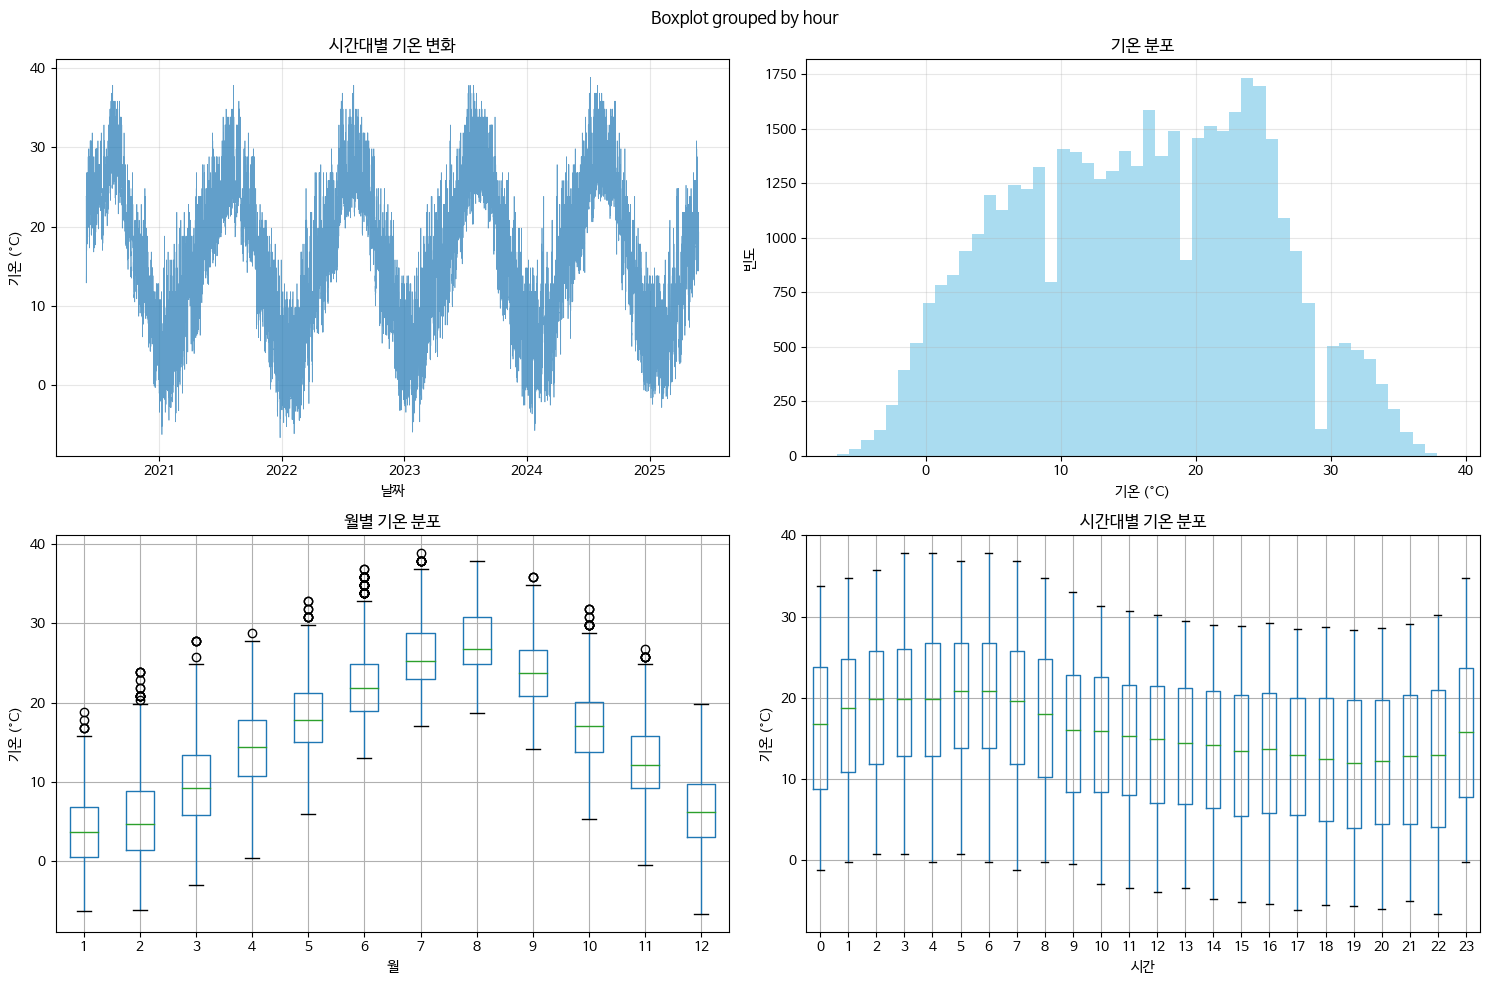

In [2]:
predictor = TokyoWeatherPredictor()
data = predictor.collect_weather_data(years=5)
predictor.explore_data()

## 데이터 분할 및 모델링

In [3]:
train_data, test_data = predictor.split_data(recent_test_days=30)
model = predictor.train_model()

📊 최근 30일을 테스트 데이터로 분할 중...
📊 데이터 분할 완료
훈련 데이터: 43080개 (2020-05-28 ~ 2025-04-27)
테스트 데이터: 720개 (2025-04-27 ~ 2025-05-27)
📅 테스트 기간: 최근 30일 (30일)
🤖 Prophet 모델 훈련 중...


03:17:28 - cmdstanpy - INFO - Chain [1] start processing
03:17:44 - cmdstanpy - INFO - Chain [1] done processing


✅ 모델 훈련 완료


## 모델 성능 시각화

📈 모델 성능 평가 중 (최근 한 달 데이터 기준)...
📊 모델 성능 지표 (최근 한 달 기준)
MAE (평균절대오차): 2.04°C
RMSE (평균제곱근오차): 2.67°C
MAPE (평균절대백분율오차): 11.41%
상관계수: 0.761
종합 성능: 🟡 양호

📅 일별 성능 분석 (최근 31일)
            실제_평균  실제_최저  실제_최고  예측_평균  예측_최저  예측_최고  평균오차  최대오차
date                                                            
2025-04-27  17.98   14.2   22.8  15.92  12.42  21.75  2.06  3.58
2025-04-28  16.18   11.3   21.8  16.54  12.39  21.83  0.70  1.75
2025-04-29  14.90    7.3   21.8  16.68  12.61  21.89  2.28  5.31
2025-04-30  16.63   10.5   23.8  16.71  12.49  22.04  1.00  2.11
2025-05-01  17.86   14.2   22.8  16.68  12.62  21.89  1.21  2.52
2025-05-02  15.28   12.5   18.8  16.95  12.86  22.19  1.96  6.12
2025-05-03  17.23   12.2   23.8  17.04  12.94  22.30  0.79  2.13
2025-05-04  17.28   12.0   24.8  17.23  13.14  22.47  1.28  2.67
2025-05-05  16.99   13.7   22.8  17.26  13.11  22.55  0.66  3.02
2025-05-06  13.26   11.6   18.8  17.41  13.35  22.62  4.30  8.85

🕐 시간대별 평균 오차 (상위 5개 시간대)
 4시: 2.91°C (±2.20°C)
 5시

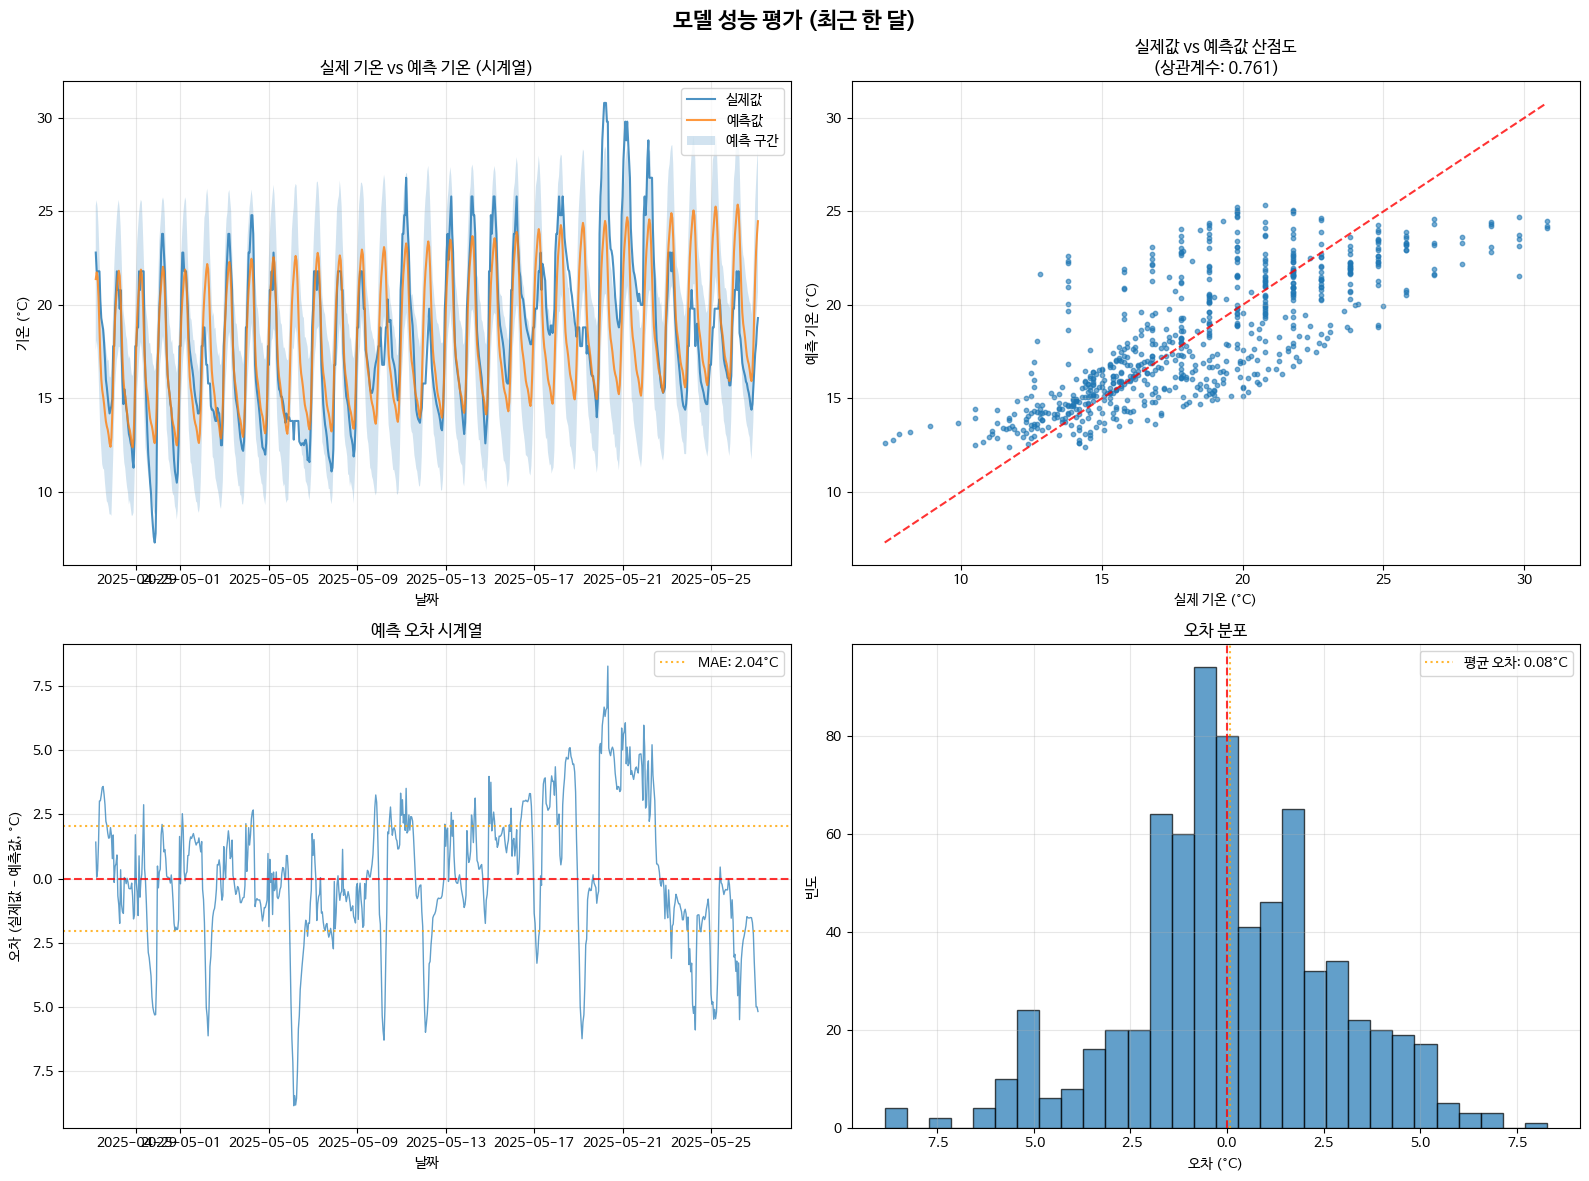

In [4]:
metrics = predictor.evaluate_model(detailed_analysis=True)

## 7일간 예측 결과 시각화

🔮 7일간의 미래 기온 예측 중...
✅ 예측 완료

📅 일별 기온 예측 요약
             최저기온   최고기온   평균기온   최저구간   최고구간
날짜시간                                         
2025-05-27  16.18  25.45  19.65  12.06  29.27
2025-05-28  16.08  25.63  20.29  12.21  29.33
2025-05-29  16.23  25.50  20.29  12.20  29.28
2025-05-30  16.49  25.82  20.58  12.31  29.61
2025-05-31  16.59  25.95  20.69  12.79  29.67
2025-06-01  16.80  26.14  20.90  12.99  30.05
2025-06-02  16.79  26.23  20.94  13.18  30.13
2025-06-03  22.36  25.34  24.03  18.75  29.11


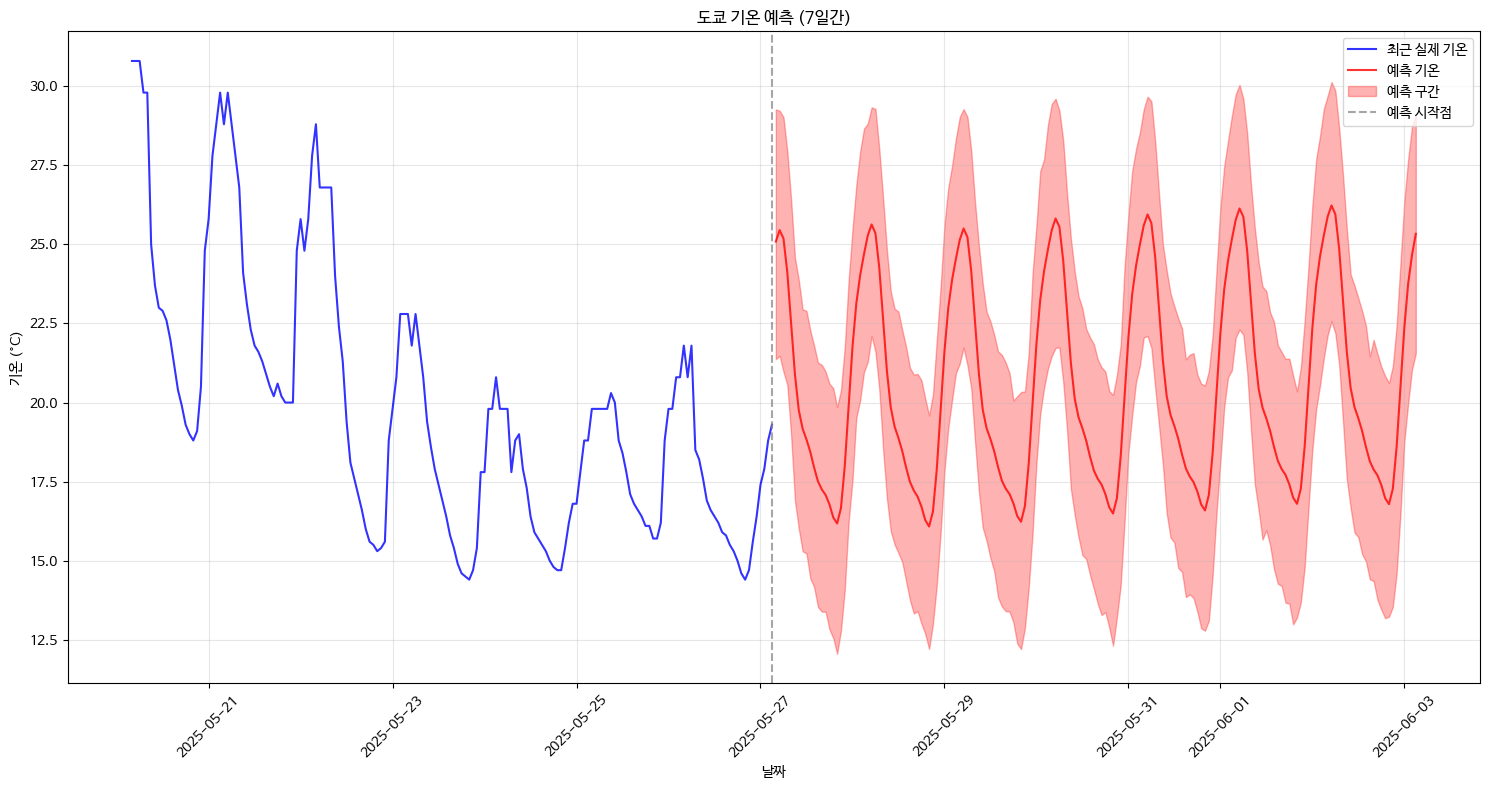

In [5]:
predictions, daily_summary = predictor.predict_future(days=7)

## 최종 결과

In [6]:
clothing_recs = predictor.generate_clothing_recommendations(predictions)

In [7]:
print("\n👔 옷차림 추천 (24시간 간격)")
print("="*80)
for i in range(0, len(clothing_recs), 24):
    rec = clothing_recs.iloc[i]
    print(f"📅 {rec['날짜시간'].strftime('%Y-%m-%d %H:%M')}")
    print(f"🌡️  기온: {rec['예측기온']:.1f}°C ({rec['기온구간']})")
    print(f"📊 상태: {rec['날씨상태']}")
    print(f"👕 추천: {rec['추천복장']}")
    print(f"💡 팁: {rec['팁']}")
    print("-" * 80)


👔 옷차림 추천 (24시간 간격)
📅 2025-05-27 04:00
🌡️  기온: 25.1°C (21.4~29.3°C)
📊 상태: 더움
👕 추천: 반팔, 긴바지, 운동화, 얇은 가디건
💡 팁: 아침저녁 기온차를 고려해 얇은 겉옷 준비
--------------------------------------------------------------------------------
📅 2025-05-28 04:00
🌡️  기온: 25.3°C (21.3~28.8°C)
📊 상태: 더움
👕 추천: 반팔, 긴바지, 운동화, 얇은 가디건
💡 팁: 아침저녁 기온차를 고려해 얇은 겉옷 준비
--------------------------------------------------------------------------------
📅 2025-05-29 04:00
🌡️  기온: 25.1°C (21.2~29.0°C)
📊 상태: 더움
👕 추천: 반팔, 긴바지, 운동화, 얇은 가디건
💡 팁: 아침저녁 기온차를 고려해 얇은 겉옷 준비
--------------------------------------------------------------------------------
📅 2025-05-30 04:00
🌡️  기온: 25.5°C (21.5~29.4°C)
📊 상태: 더움
👕 추천: 반팔, 긴바지, 운동화, 얇은 가디건
💡 팁: 아침저녁 기온차를 고려해 얇은 겉옷 준비
--------------------------------------------------------------------------------
📅 2025-05-31 04:00
🌡️  기온: 25.6°C (22.1~29.3°C)
📊 상태: 더움
👕 추천: 반팔, 긴바지, 운동화, 얇은 가디건
💡 팁: 아침저녁 기온차를 고려해 얇은 겉옷 준비
--------------------------------------------------------------------------------
📅 2025-06-01 04